In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
pd.set_option('display.max_Columns', 100)

In [2]:
train_ = pd.read_feather('../inputs/train_feature.f')
print(train_.shape)
test_ = pd.read_feather('../inputs/test_feature.f')
print(test_.shape)

(8359, 982)
(8360, 977)


In [3]:
n_fold = 5

In [4]:
train_.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,...,WD_surfer,WD_faction,WD_gears,WD_slug,WD_tenchu,WD_dual,WD_joker,WD_others,WD_rivals,WD_professor,WD_crimson,WD_godzilla,WD_skies,WD_hakusho,WD_prophecy,WD_wings,WD_champion,WD_codename,WD_medieval,WD_town,WD_century,WD_atlantis,WD_scene,WD_rome,WD_dino,WD_groove,WD_volleyball,WD_wario,WD_machi,WD_mirai,WD_studio,WD_bandicoot,WD_director,WD_wall,WD_yoru,WD_kane,WD_west,WD_unreal,WD_turismo,WD_redemption,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,LEGO Batman: The Videogame,23,0,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,425,1,0,8.0,7.0,3.135494,2010.0,1320,3370,235,77,1420,2830,2019,93.604962,61.883755,49.257785,106.536082,49.231678,59.678899,52.633663,56.848214,289.223684,112.428571,64.319444,81.140351,48.326531,50.646154,56.630137,444.419232,148.275892,72.187084,341.484617,73.847985,96.258706,76.873366,69.018125,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000142,0.000142,0.807465,0.000142,0.000142,0.031338,0.160205,0.000142,0.000142,0.000142
1,LEGO Indiana Jones: The Original Adventures,23,0,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,425,1,0,7.0,8.0,3.367296,2008.0,1320,3370,90,77,1420,1634,2366,96.597250,58.394680,49.148789,66.403374,101.466970,54.090000,48.867470,52.439815,213.160000,54.335079,58.293233,483.589744,89.802260,75.231343,96.758065,462.863031,120.188797,75.206074,174.818593,341.906251,91.001509,72.338596,62.128944,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.039358,0.157024,0.129704,0.000369,0.000369,0.147072,0.075802,0.000369,0.413444,0.036489
2,LEGO Batman: The Videogame,17,0,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,425,1,0,7.0,7.0,2.397895,2010.0,1209,3370,235,77,1420,1634,2019,29.606403,59.681720,53.568595,64.981846,46.931655,48.185714,53.033898,58.454936,31.886792,58.615789,60.314286,45.701493,47.107692,53.884615,57.709821,69.859005,132.194405,81.714638,150.222097,77.663440,114.136366,82.460642,74.957223,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000142,0.000142,0.807465,0.000142,0.000142,0.031338,0.160205,0.000142,0.000142,0.000142
3,Combat,0,0,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,467,6,0,NaN,NaN,NaN,1982.0,133,3370,367,6623,6769,9129,8582,65.943662,62.435252,NaN,NaN,NaN,52.269231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.197493,149.649097,NaN,NaN,NaN,49.684249,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.019402,0.159094,0.000091,0.000091,0.000091,0.046073,0.011695,0.073007,0.690365,0.000091
4,LEGO Harry Potter: Years 5-7,23,0,Warner 

In [5]:
test_.head()

,Name,Platform,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,TGE_Global_Sales_std_by_User_Score_int_Platform,TGE_Global_Sales_std_by_User_Score_int_Genre,TGE_Global_Sales_std_by_User_Score_int_Rating,TGE_Global_Sales_std_by_Critic_Score_int_Platform,TGE_Global_Sales_std_by_Critic_Score_int_Genre,...,WD_surfer,WD_faction,WD_gears,WD_slug,WD_tenchu,WD_dual,WD_joker,WD_others,WD_rivals,WD_professor,WD_crimson,WD_godzilla,WD_skies,WD_hakusho,WD_prophecy,WD_wings,WD_champion,WD_codename,WD_medieval,WD_town,WD_century,WD_atlantis,WD_scene,WD_rome,WD_dino,WD_groove,WD_volleyball,WD_wario,WD_machi,WD_mirai,WD_studio,WD_bandicoot,WD_director,WD_wall,WD_yoru,WD_kane,WD_west,WD_unreal,WD_turismo,WD_redemption,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,Hitman 2: Silent Assassin,26,0,Eidos Interactive,84.0,23.0,8.0,19.0,216,3,0,8.0,8.0,2.995732,2004.0,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,100.864791,99.177204,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,34.246377,90.017778,88.489083,111.091346,64.594512,139.218459,203.600983,320.473808,323.717868,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,44.125958,95.640508,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.165131,0.200474,0.000168,0.000168,0.000168,0.08752,0.000168,0.011961,0.534073,0.000168
1,Legacy of Kain: Soul Reaver,13,0,Eidos Interactive,91.0,17.0,9.0,132.0,112,5,0,9.0,9.0,4.890349,1999.0,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,126.789762,201.134986,72.709091,230.451613,51.920228,325.000000,156.375000,104.608491,412.666667,190.612903,164.576923,215.804348,129.886997,139.218459,99.850190,235.111932,327.145440,108.623828,289.354320,96.611679,360.629311,287.232653,191.872644,328.886578,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.165131,0.200474,0.000168,0.000168,0.000168,0.08752,0.000168,0.011961,0.534073,0.000168
2,Metal Gear Solid 2: Substance,26,0,Konami Digital Entertainment,87.0,28.0,8.5,39.0,469,3,0,8.0,9.0,3.688879,2004.0,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,100.864791,201.134986,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,57.935484,190.612903,201.981308,201.214689,64.594512,139.218459,203.600983,320.473808,327.145440,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,52.441037,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.076232,0.101225,0.009725,0.108554,0.063932,0.00004,0.016500,0.523117,0.058425,0.042250
3,Silent Hill: Homecoming,25,0,Konami Digital Entertainment,70.0,54.0,6.9,180.0,134,3,0,7.0,7.0,5.198497,2010.0,1262,3370,834,22,1563,1634,2019,81.399660,61.011474,96.410622,

In [6]:
lgbm_param = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'seed' : 0,
    'learning_rate':  0.01,
#     'lambda_l1': 1.9090472958000438e-07, 
#     'lambda_l2': 1.3091776726058165e-07, 
#     'num_leaves': 64, 
#     'feature_fraction': 0.5, 
#     'bagging_fraction': 1.0, 
#     'bagging_freq': 0, 
#     'min_child_samples': 20,
    'max_depth': 6,
    'colsample_bytree': .5,
    'importance_type': 'gain',
    'verbose': -1
}

In [7]:
def tuning_lgbm(X, y, group, params, verbose=100):
    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    tr_group_idx, va_group_idx = list(cv)[4]
        
    train_groups = unique_group[tr_group_idx]
    valid_groups = unique_group[va_group_idx]
    is_train = group.isin(train_groups)
    is_valid = group.isin(valid_groups)
        
    x_train, y_train = X[is_train], y[is_train]
    x_valid, y_valid = X[is_valid], y[is_valid]
    
    lgbm_train = lgbm.Dataset(x_train, y_train)
    lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
    
    best_params, tuning_history = dict(), list()
    best = lgbm.train(params,
                                  lgbm_train,
                                  valid_sets=lgbm_eval,
                                  num_boost_round=10000,
                                  early_stopping_rounds=verbose,
                                  verbose_eval=0)
    print('Best Params:', best.params)
    print('Best Iteration:', best.best_iteration)
    print('Best Score:', best.best_score)

In [8]:
# y = train_['Global_Sales'].apply(np.log1p)
# group = train_['Publisher'].copy()
# train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
# tuning_lgbm(train_, y, group, lgbm_param)

In [9]:
def create_bin_y_folds(X, y):
    num_bins = np.int(1 + np.log2(len(X)))
    print('num_bins: ', num_bins)
    bins = pd.qcut(y, q=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = kf.split(X=X, y=bins.values)
    return cv

In [10]:
def create_normal_folds(X, y):
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(X)
    return cv

In [11]:
def train_lgbm(X, y, params: dict, verbose=100):

#   cv = create_normal_folds(X, y)
    cv = create_bin_y_folds(X, y)
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[idx_valid] = y_pred
        models.append(lgbm_model)
        print('--- Fold {} Score: {:.4f} ---'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('--- FINISHED \ whole score: {:.4f} ---'.format(score))
    return oof_pred, models, score

In [12]:
def train_lgbm_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[is_valid] = y_pred
        models.append(lgbm_model)
        print('--- Fold {} Score: {:.4f} ---'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('--- FINISHED \ whole score: {:.4f} ---'.format(score))
    return oof_pred, models, score

In [13]:
def train_pred(train_df, y, test_df, group):
#     oof, models, score = train_lgbm_group(train_df, y, group, lgbm_param)
    oof, models, score = train_lgbm(train_df, y, lgbm_param)
    
    pred_list = []
    for i, model in enumerate(models):
            pred = model.predict(test_df, num_iteration = model.best_iteration)
            pred = np.expm1(pred)
            
            pred_list.append(pred)
            print(i, pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [14]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [15]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

num_bins:  14
x_train (6687, 975)
x_valid (1672, 975)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3114]	valid_0's rmse: 0.857144
--- Fold 0 Score: 0.8571 ---
x_train (6687, 975)
x_valid (1672, 975)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4097]	valid_0's rmse: 0.856331
--- Fold 1 Score: 0.8563 ---
x_train (6687, 975)
x_valid (1672, 975)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
Early stopping

In [16]:
feature_importance(models).head(50)

,name,imp_0,imp_1,imp_2,imp_3,imp_4,sum
974,Year,2289,2764,2826,2891,3092,13862
973,TGE_Global_Sales_mean_by_Platform_Genre,1228,1812,2044,2133,2522,9739
971,TGE_Global_Sales_std_by_Platform_Genre,1054,1655,1745,1833,1788,8075
972,User_Count,1163,1319,1476,1411,1520,6889
970,TGE_Global_Sales_mean_by_Platform,937,1107,1211,1415,1397,6067
969,TGE_Global_Sales_mean_by_Genre,764,888,1271,1201,1233,5357
968,TGE_Global_Sales_std_by_Platform,691,828,992,1038,1269,4818
965,TGE_Global_Sales_std_by_Genre,560,827,1045,987,1085,4504
967,Critic_Count,582,920,898,1082,957,4439
966,User_Count_log,567,688,727,754,768,3504


In [17]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test_)

(8360, 1)
mean= 26.409596068809766
max= 555.1311020385616


Text(0.5, 0, 'Global_Sales')

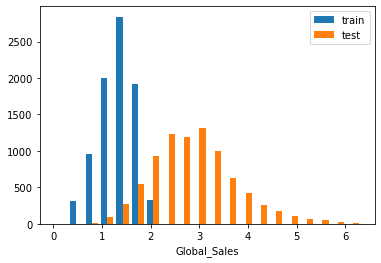

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [19]:
FILENAME = 'submission_lgbm.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission_lgbm.csv


In [20]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- lgbm = {:.4f}'.format(score))

- feat = 975
- mean = 26.4096
- max = 555.1311
- lgbm = 0.8533


#### 30 lgbm:
- feat = 975
- mean = 26.4096
- max = 555.1311
- lgbm = 0.8533 (lr=0.01, max_depth=6)
- LB= 0.8952

#### 29lgbm: Name減らす
- feat = 985
- mean = 22.8474
- max = 663.3873
- lgbm = 0.8394

#### 28: groupKfold -> StratifiedKFold
- feat = 1431
- mean = 26.2728
- max = 777.4122
- lgbm = 0.8525 (lr=0.01, max_depth=6)
- LB= 0.9070

#### 27: lgbm(0.7)+cat(0.3)
- feat = 1431
- mean = 24.8166
- max = 623.9319
- lgbm = 1.0393 (lr=0.01, max_depth=6)
- cat = 1.0556
- LB= 0.8976

#### 26: lgbm: Developer-LDA
- feat = 1442
- mean = 22.7842
- max = 518.6651
- lgbm = 1.0448 (lr=0.1, max_depth=6)
- LB= 0.9113

#### 25-1: lgbm: Year, Devloper
- feat = 1432
- mean = 26.3477
- max = 474.2778
- lgbm = 1.0517 (lr=0.1, max_depth=6)
- LB= 0.909

#### 22: lgbm(0.7)+cat(0.3) Publisher-LDA
- feat = 1432
- mean = 26.4448
- max = 536.7920
- lgbm = 1.0752
- cat =  1.0980
- LB= 0.8911　★best★